In [0]:

import os
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LogisticRegression, RandomForestClassifier  # NOQA.
from pyspark.ml.feature import OneHotEncoder, StandardScaler, StringIndexer, VectorAssembler
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number, when
import string
import time

# Directory where CSV files of model results are located:
LOCAL_CSV_DIR = "/dbfs/team8_results"

# URL of spark distributed datasets:
BLOB_URL = f"wasbs://w261team8rocks@dataguru.blob.core.windows.net"


def load_results_csv(filename: str) -> pd.DataFrame:
    """Load a single file of grid-search results from CSV directory."""
    fp = os.path.join(LOCAL_CSV_DIR, filename)
    return pd.read_csv(fp, encoding="utf-8")


def deduplicate_gridsearch_results():
    """When the grid-search class runs it saves intermediate results once each
    version of a model has finished training. This results in duplicates of
    model results in the local directory. This method identifies duplicate
    results by the 6-letter random identifier, merges them to 1 dataframe which
    is saved back to CSV, and then deletes all the intermediate results files.
    """
    files = [f for f in os.listdir(LOCAL_CSV_DIR) if f.endswith(".csv")]

    # Grid-search results use a 6-character unique random identifier plus a space:
    files = [f for f in files if len(f.split("-")[0]) == 7]
    random_identifiers = set([f[:6] for f in files])
    for ri in random_identifiers:
        # Combine all intermediate results into 1 df and de-duplicate:
        print(ri, end=": ")
        dupe_files = [f for f in files if f[:6] == ri]
        df = pd.DataFrame()
        for dupe_name in dupe_files:
            dupe_path = os.path.join(LOCAL_CSV_DIR, dupe_name)
            dupe_df = pd.read_csv(dupe_path, encoding="utf-8")
            df = df.append(dupe_df)
        for date_col in ["train_min_date", "train_max_date", "test_min_date", "test_max_date"]:
            df[date_col] = pd.to_datetime(df[date_col])
        duped_n = len(df)
        subset = [c for c in df.columns if c != "timestamp"]
        df = df.drop_duplicates(subset=subset)
        deduped_n = len(df)
        print(f"Dropped {duped_n-deduped_n:,} duplicates")

        # Save de-duplicated file:
        filename = f"{ri}_DEDUPED {dupe_files[0][9:]}"
        df.to_csv(os.path.join(LOCAL_CSV_DIR, filename), encoding="utf-8", index=False)  # NOQA.

        # Delete original files:
        for f in dupe_files:
            os.remove(os.path.join(LOCAL_CSV_DIR, f))


def aggregate_cv_results(name: str, beta: float = 2.0) -> pd.DataFrame:
    """Calculate the average model performance across all CV iterations for a
    single grid search.

    Args:
        name: filename of CSVs with model results saved to local storage.
        beta: parameter for calculating f-beta score.
    """
    # Load raw results and add metric scores:
    raw = load_results_csv(name)
    tp, fp, tn, fn = raw["tp"], raw["fp"], raw["tn"], raw["fn"]
    total = raw[["tp", "fp", "tn", "fp"]].sum(axis=1)
    raw["accuracy"] = (tp + tn) / total
    raw["precision"] = tp / (tp + fp)
    raw["recall"] = tp / (tp + fn)
    raw["fbeta"] = (1+beta**2) * ((raw["precision"] * raw["recall"]) /
                                  ((beta**2 * raw["precision"]) + raw["recall"]))

    # Average scores in each CV iteration:
    mins = {c: "min" for c in ["train_min_date", "test_min_date"]}
    maxs = {c: "max" for c in ["train_max_date", "test_max_date"]}
    sums = {c: "sum" for c in ["tp", "fp", "tn", "fn"]}
    means = {c: "mean" for c in {"training_time", "accuracy", "precision", "recall", "fbeta"} & set(raw.columns)}
    agg_df = raw.groupby("parameters").agg({**mins, **maxs, **sums, **means}).reset_index()
    add_cols = {"model", "static_params", "numeric_features", "categorical_features", "one_hot_encode_features",
                "target", "timestamp", "class_weights", "scale_features"} & set(raw.columns)
    merged = pd.merge(raw[["parameters"] + list(add_cols)].drop_duplicates(), agg_df, on="parameters")
    merged["beta"] = beta

    return merged


def compare_models(*name: str, beta: float = 2.0) -> pd.DataFrame:
    """Compare multiple models from different gridsearches, ordering results by
    fbeta score."""
    dfs = list()
    for n in name:
        try:
            model_results = aggregate_cv_results(n, beta)
            model_results["filename"] = n
            dfs.append(model_results)
        except KeyError:
            continue
    df = pd.concat(dfs)

    # Filter out results which didn't complete the full cross-validation:
    for date_col in ["train_min_date", "train_max_date", "test_min_date", "test_max_date"]:
        df[date_col] = pd.to_datetime(df[date_col])
    df = df[(df["train_max_date"] >= "2017-12-1")]

    return df.sort_values(by=["fbeta", "training_time"], ascending=[False, True]).reset_index(drop=True)


def train_final_model(train_name: str, model_params: pd.Series):
    """Train a model on the full training dataset."""

    start_time = time.time()  # For tracking how long training takes.
    print(f"Start training on entire training dataset: {train_name}")

    train = spark.read.parquet(f"{BLOB_URL}/{train_name}")  # NOQA.

    # Get the name of column being predicted and add target to train:
    target = model_params.get("target", "DEP_DEL15")
    train = train.withColumn("target", train[target])
    train.cache()

    # Apply class weight column:
    class_weights = model_params.get("class_weights", False)
    if class_weights:
        class_weights = train.groupBy(target).count().collect()
        not_delayed = [r["count"] for r in class_weights if r[target] == 0][0]
        delayed = [r["count"] for r in class_weights if r[target] == 1][0]
        ratio = not_delayed / delayed
        train = train.withColumn("weight", when(train[target] > 0, ratio).otherwise(1))

    # Create the final model pipeline:

    # Get the lists of numeric/categorical/one-hot-encoded features:
    num_features, cat_features, cat_features_ohe = list(), list(), list()
    num_features = model_params.get("numeric_features", num_features)
    if isinstance(num_features, str):  # List stored as string.
        num_features = eval(num_features)
    cat_features = model_params.get("categorical_features", cat_features)
    if isinstance(cat_features, str):  # List stored as string.
        cat_features = eval(cat_features)
    cat_features_ohe = model_params.get("one_hot_encode_features", cat_features_ohe)
    if isinstance(cat_features_ohe, str):  # List stored as string.
        cat_features_ohe = eval(cat_features_ohe)

    # Parameter for handling invalid data in pyspark.ml.feature classes.
    # Use default option of 'error' as this wasn't tracked in earlier versions:
    handle_invalid = model_params.get("handle_invalid", "error")

    # Build the pipeline stages:
    pipeline_stages, final_features = list(), list()

    # One-Hot-Encoded categorical features:
    already_string_indexed = list()
    if isinstance(cat_features_ohe, list) and len(cat_features_ohe):
        ix_output_cols = [f"{c}_ix" for c in cat_features_ohe]
        ohe_ix = StringIndexer(inputCols=cat_features_ohe, outputCols=ix_output_cols, handleInvalid=handle_invalid)
        ohe_output_cols = [f"{c}_ohe" for c in cat_features_ohe]
        ohe = OneHotEncoder(inputCols=ix_output_cols, outputCols=ohe_output_cols, handleInvalid=handle_invalid)
        pipeline_stages += [ohe_ix, ohe]
        final_features += ohe_output_cols
        already_string_indexed += cat_features_ohe  # So the features don't get indexed again below.

    # Other categorical features, not One-Hot-Encoded:
    if isinstance(cat_features, list) and len(cat_features):
        not_yet_indexed = [c for c in cat_features if c not in already_string_indexed]
        cat_output_cols = [f"{c}_ix" for c in not_yet_indexed]
        cat_ix = StringIndexer(inputCols=not_yet_indexed, outputCols=cat_output_cols, handleInvalid=handle_invalid)
        pipeline_stages.append(cat_ix)
        final_features += cat_output_cols

    # Numeric features:
    if isinstance(num_features, list) and len(num_features):
        num_va = VectorAssembler(inputCols=num_features, outputCol="num_features", handleInvalid=handle_invalid)
        pipeline_stages.append(num_va)
        if model_params.get("scale_features", False):  # Apply standard scaling:
            scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features",
                                    withMean=True, withStd=True)
            pipeline_stages.append(scaler)
            final_features.append("scaled_num_features")
        else:
            final_features.append("num_features")

    # Create final features:
    feature_assembler = VectorAssembler(inputCols=final_features, outputCol="features")
    pipeline_stages.append(feature_assembler)

    # Create the model instance:
    full_model_name = model_params["model"]
    estimator_name = "".join(filter(lambda s: s in string.ascii_letters, full_model_name.split(".")[-1]))
    estimator_class = eval(estimator_name)
    parameters = model_params.get("parameters", dict())
    if isinstance(parameters, str):  # Dict stored as string.
        parameters = eval(parameters)
    static_params = model_params.get("static_params", dict())
    if isinstance(static_params, str):  # Dict stored as string.
        static_params = eval(static_params)
    full_params = {**parameters, **static_params}
    print(f"Best params = {full_params}")
    model = estimator_class(labelCol="target", featuresCol="features", **full_params)

    # Create the full pipeline:
    pipeline = Pipeline(stages=pipeline_stages + [model]).fit(train)
    print(f"--- {time.time() - start_time:.2f} seconds ---")

    train.unpersist()
    return pipeline, final_features


def make_predictions(fitted_pipeline, test_name: str):
    """Make predictions with the fitted model on the test set and return the
    final confusion matrix."""
    # Make the final test set predictions and calculate confusion matrix:
    start_time = time.time()  # For tracking how long test predictions takes.
    print(f"Start predicting on test dataset: {test_name}")
    test = spark.read.parquet(f"{BLOB_URL}/{test_name}")  # NOQA.
    test = test.withColumn("target", test["DEP_DEL15"])
    test.cache()
    test_pred = fitted_pipeline.transform(test)

    # Compute the confusion matrix:
    spark_cm = test_pred.groupBy("prediction").pivot("target").count()
    pd_cm = spark_cm.toPandas()
    print(f"--- {time.time() - start_time:.2f} seconds ---")
    test.unpersist()

    return test_pred, pd_cm


def top_3_models(ranked_models: pd.DataFrame):
    """Get the best model each for RandomForest, GradientBoostedTrees, and
    Logistic Regression.

    Args:
        ranked_models: output from `compare_models`.
    """
    rfs = ranked_models[(ranked_models["model"].str.contains("RandomForest"))]
    gbts = ranked_models[(ranked_models["model"].str.contains("GBTClassifier"))]
    lrs = ranked_models[(ranked_models["model"].str.contains("Logistic"))]
    df = pd.concat([rfs.iloc[0], gbts.iloc[0], lrs.iloc[0]], axis=1).T
    df.index = ["RandomForest", "GBTClassifier", "LogisticRegression"]
    return df


class Ensemble:

    def __init__(self, ranked_models: pd.DataFrame, train_name: str,
                 test_name: str):
        """Create an ensemble model which predicts the majority vote of the best
        scoring GBTClassifier, LogisticRegression, RandomForestClassifier found
        via grid-searches."""
        self.ranked_models = ranked_models
        self.train_name = train_name
        self.test_name = test_name

        # Identify best model for each estimator class:
        self.best_models = top_3_models(ranked_models)

        # Fit pipelines for each estimator on full training data:
        self.pipelines = dict()
        self.features = dict()
        for model_name, row in self.best_models.iterrows():
            print(f"Training {model_name}")
            fitted_pipeline, features = train_final_model(train_name, row)
            self.pipelines[model_name] = fitted_pipeline
            self.features[model_name] = features

        # Get the test dataset and add an index so that predictions from all 3 models can be joined.
        test = spark.read.parquet(f"{BLOB_URL}/{test_name}")  # NOQA.
        test = test.withColumn("target", test["DEP_DEL15"])
        test = test.withColumn("index", row_number().over(Window.orderBy(monotonically_increasing_id()))-1)

        # Get predictions from each estimator on test data:
        self.predictions = dict()
        self.confusion_matrices = dict()
        for model_name, fitted_model in self.pipelines.items():
            start_time = time.time()  # For tracking how long test predictions takes.
            print(f"{model_name}: Start predicting on test dataset: {test_name}")
            model_pred = fitted_model.transform(test)
            model_pred = model_pred.withColumn(f"pred_{model_name}", model_pred["prediction"])
            spark_cm = model_pred.groupBy("prediction").pivot("target").count()
            model_cm = spark_cm.toPandas()
            self.predictions[model_name] = model_pred
            self.confusion_matrices[model_name] = model_cm
            print(f"--- {time.time() - start_time:.2f} seconds ---")

        # Merge predictions from all 3 models into single test dataframe.
        rf_pred = self.predictions["RandomForest"]
        gbt_pred = self.predictions["GBTClassifier"]
        lr_pred = self.predictions["LogisticRegression"]
        ensmb_pred = rf_pred.join(gbt_pred[["index", "pred_GBTClassifier"]], on=["index"], how="inner")  # NOQA.
        ensmb_pred = ensmb_pred.join(lr_pred[["index", "pred_LogisticRegression"]], on=["index"], how="inner")  # NOQA.

        # Sum all 3 predictions; where sum > 1 ensemble predicts 1 else 0:
        ensmb_pred = ensmb_pred.withColumn(
            "pred_sum",
            ensmb_pred["pred_RandomForest"] + ensmb_pred["pred_GBTClassifier"] + ensmb_pred["pred_LogisticRegression"]
        )
        ensmb_pred = ensmb_pred.withColumn("final_pred", when(ensmb_pred["pred_sum"] > 1, 1).otherwise(0))
        ensemble_spark_cm = ensmb_pred.groupBy("final_pred").pivot("target").count()
        ensemble_cm = ensemble_spark_cm.toPandas()

        # Store the ensemble predictions and confusion matrix:
        self.predictions["ensemble"] = ensmb_pred
        self.confusion_matrices["ensemble"] = ensemble_cm.rename(columns={"final_pred": "prediction"})

    def final_table(self, beta: float = 2.0):
        """Compute the final table of results from all models."""
        # Compile model confusion matrices into a table:
        tbl = pd.DataFrame(columns="model tp tn fp fn".split())
        for model_name, conf_mat in self.confusion_matrices.items():
            tbl_row = {"model": model_name}
            cm = conf_mat.set_index("prediction")
            tbl_row["tp"] = cm.loc[1.0, "1.0"]
            tbl_row["tn"] = cm.loc[0.0, "0.0"]
            tbl_row["fp"] = cm.loc[1.0, "0.0"]
            tbl_row["fn"] = cm.loc[0.0, "1.0"]
            tbl = tbl.append(tbl_row, ignore_index=True)

        # Calculate evaluation metrics:
        tp, fp, tn, fn = tbl["tp"], tbl["fp"], tbl["tn"], tbl["fn"]
        total = tbl[["tp", "fp", "tn", "fp"]].sum(axis=1)
        tbl["accuracy"] = (tp + tn) / total
        tbl["precision"] = tp / (tp + fp)
        tbl["recall"] = tp / (tp + fn)
        tbl[f"fbeta (beta={beta:.2f})"] = (1+beta**2) * ((tbl["precision"] * tbl["recall"]) /
                                                         ((beta**2 * tbl["precision"]) + tbl["recall"]))
        return tbl


if __name__ == "__main__":

    # Merge and deduplicate all the intermediate results files saved in the grid-searches:
    deduplicate_gridsearch_results()

    # List all the merged grid-search results files which will be compared to identify the best performing models:
    gridsearch_result_csvs = [f for f in os.listdir(LOCAL_CSV_DIR) if f.endswith(".csv")]

    # Choose the best performing model for each classifier based on F-Beta score:
    models_ranked: pd.DataFrame = compare_models(*gridsearch_result_csvs)

    # Create the Ensemble class. Trains an instance of each of the best performing models on the full training data and
    # uses it to make predictions on the held out test data. Predictions are summed to get the majority vote which is
    # the ensemble model's prediction (1 if sum is 2 or greater, else 0).
    # Model instances are accessible in the `pipelines` attribute of the Ensemble class.
    ensemble = Ensemble(models_ranked, train_name="ML_train_filled", test_name="ML_test_filled")

    # Summarize the final test set results for all 3 models and the ensemble:
    final_results = ensemble.final_table(beta=2.0)


Training RandomForest
Start training on entire training dataset: ML_train_filled
Best params = {'maxDepth': 7, 'numTrees': 40, 'weightCol': 'weight', 'maxBins': 100}
--- 1596.21 seconds ---
Training GBTClassifier
Start training on entire training dataset: ML_train_filled
Best params = {'maxDepth': 2, 'maxIter': 75, 'minInstancesPerNode': 1, 'stepSize': 0.1, 'maxBins': 100, 'weightCol': 'weight'}

# Get tree models feature importance

In [0]:
import matplotlib.pyplot as plt

def plot_feature_importance(fi: dict, model_name: str, top: int = 10):
    fi_df = pd.DataFrame({"Feature Name": fi.keys(), "Importance": fi.values()})
    # Remove _ix suffix from PySpark feature creation:
    fi_df["Feature Name"] = [s.replace("_ix", "") for s in fi_df["Feature Name"].values]
    fi_df = fi_df.set_index("Feature Name").sort_values("Importance", ascending=False).head(top)

    fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
    fi_df.iloc[::-1].plot(kind="barh", title = f"{model_name} Feature Importance", ax=ax)

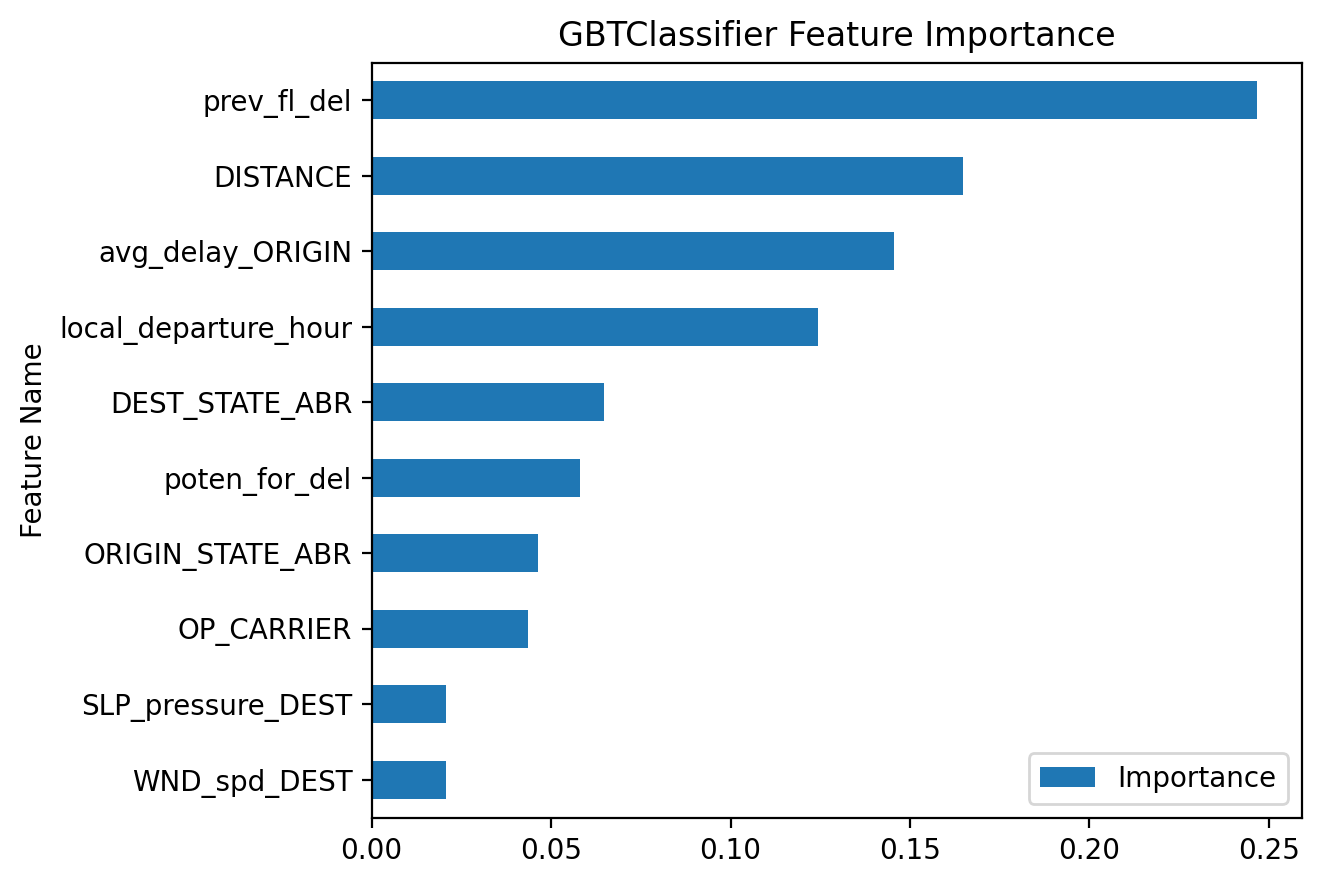

In [0]:
gbt_pipeline = ensemble.pipelines["GBTClassifier"]
gbt = gbt_pipeline.stages[-1]
feature_names = gbt_pipeline.stages[2].getInputCols() + gbt_pipeline.stages[1].getInputCols()
feature_importance_dict = dict(zip(feature_names, gbt.featureImportances))

plot_feature_importance(feature_importance_dict, "GBTClassifier")

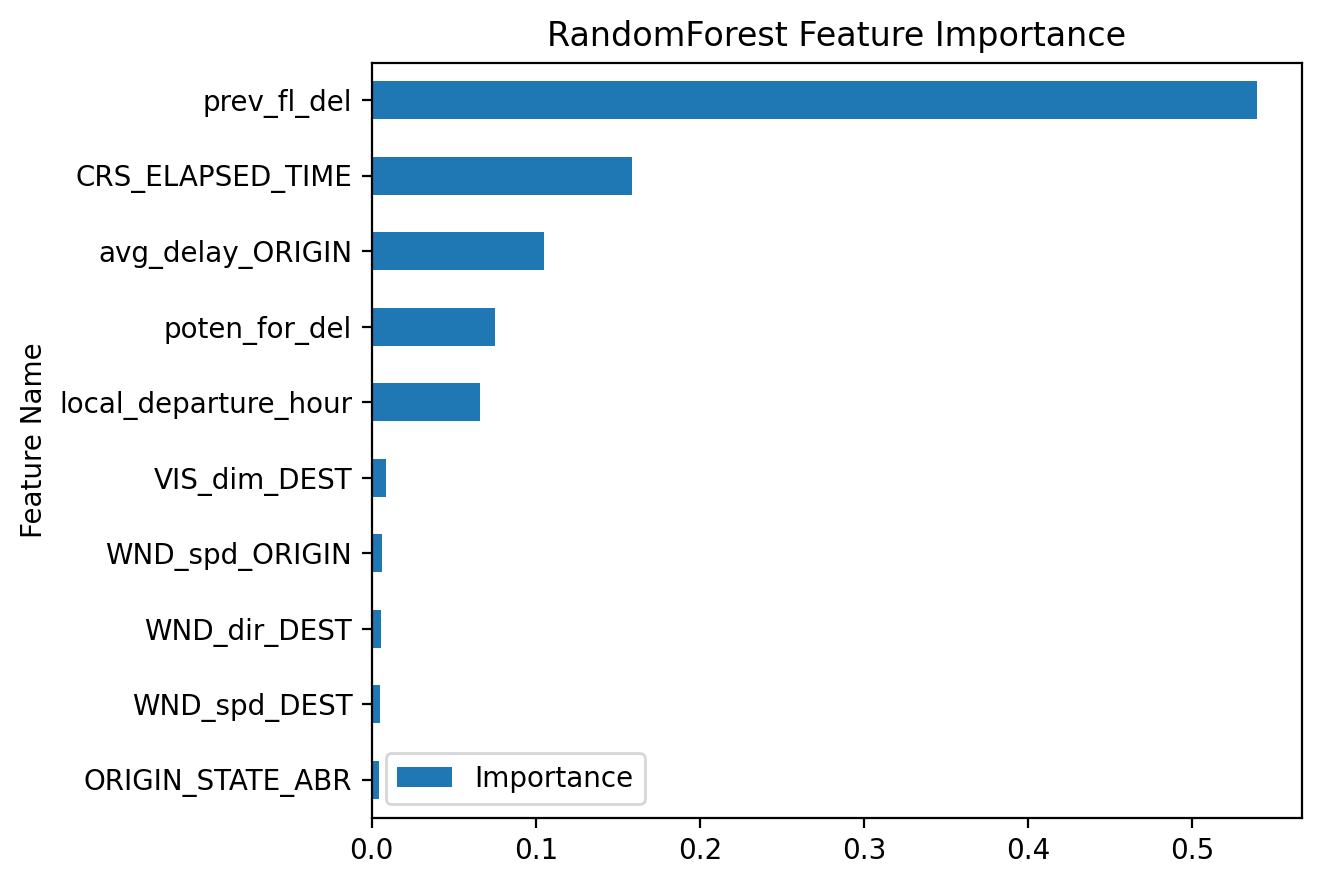

In [0]:
rf_pipeline = ensemble.pipelines["RandomForest"]
feature_names = rf_pipeline.stages[2].getInputCols() + rf_pipeline.stages[1].getInputCols()
rf = rf_pipeline.stages[-1]
feature_importance_dict = dict(zip(feature_names, rf.featureImportances))

plot_feature_importance(feature_importance_dict, "RandomForest")